Airline Price Prediction using XGBRegressor & RandomForestRegressor Model

In [1]:
# Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit , RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.metrics import r2_score

In [2]:
## Load the Airline Train Data from local drive

from google.colab import files
import io
uploaded = files.upload()

df = pd.read_csv(io.StringIO(uploaded['flightdata.csv'].decode('utf-8')))


Saving flightdata.csv to flightdata.csv


In [3]:
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [4]:
df.shape



(10683, 11)

In [5]:
## Load the Airline Test Data from local drive

from google.colab import files
import io
uploaded = files.upload()

df1 = pd.read_csv(io.StringIO(uploaded['flighttestdata.csv'].decode('utf-8')))


Saving flighttestdata.csv to flighttestdata.csv


In [6]:
df1.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
0,Jet Airways,6/06/2019,Delhi,Cochin,DEL → BOM → COK,17:30,04:25 07 Jun,10h 55m,1 stop,No info
1,IndiGo,12/05/2019,Kolkata,Banglore,CCU → MAA → BLR,06:20,10:20,4h,1 stop,No info
2,Jet Airways,21/05/2019,Delhi,Cochin,DEL → BOM → COK,19:15,19:00 22 May,23h 45m,1 stop,In-flight meal not included
3,Multiple carriers,21/05/2019,Delhi,Cochin,DEL → BOM → COK,08:00,21:00,13h,1 stop,No info
4,Air Asia,24/06/2019,Banglore,Delhi,BLR → DEL,23:55,02:45 25 Jun,2h 50m,non-stop,No info


In [7]:
df1.shape

(2671, 10)

Combine both datasets for purpose of ML

In [8]:
df3 = df.append(df1, sort = False)

In [9]:
df3.shape

(13354, 11)

In [10]:
df3.head(3)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897.0
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662.0
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882.0


Perform EDA & Data Preprocessing

In [11]:

df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13354 entries, 0 to 2670
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Airline          13354 non-null  object 
 1   Date_of_Journey  13354 non-null  object 
 2   Source           13354 non-null  object 
 3   Destination      13354 non-null  object 
 4   Route            13353 non-null  object 
 5   Dep_Time         13354 non-null  object 
 6   Arrival_Time     13354 non-null  object 
 7   Duration         13354 non-null  object 
 8   Total_Stops      13353 non-null  object 
 9   Additional_Info  13354 non-null  object 
 10  Price            10683 non-null  float64
dtypes: float64(1), object(10)
memory usage: 1.2+ MB


In [17]:
df3.describe()

,Price
count,13354.000000
mean,9087.064121
std,4124.447805
min,1759.000000
25%,6135.250000
50%,9087.064121
75%,11087.000000
max,79512.000000


In [13]:
# Check for NULL Values

df3.isnull().sum()

Airline               0
Date_of_Journey       0
Source                0
Destination           0
Route                 1
Dep_Time              0
Arrival_Time          0
Duration              0
Total_Stops           1
Additional_Info       0
Price              2671
dtype: int64

In [14]:
  #  Fill Price NULL values with the Mean value

df3['Price'].fillna((df3['Price'].mean()), inplace = True)


In [16]:
 #  Fill Total_Stops NULL values with '1 stop'

df3['Total_Stops'].value_counts()

df3['Total_Stops'] = df3['Total_Stops'].fillna('1 stop')

In [22]:
#  Fill Total_Stops NULL values with 'DEL → BOM → COK'

df3['Route'].value_counts()

#df3['Route'] = df3['Route'].fillna('DEL → BOM → COK')

DEL → BOM → COK          3001
BLR → DEL                1941
CCU → BOM → BLR          1232
CCU → BLR                 896
BOM → HYD                 785
                         ... 
CCU → IXA → BLR             1
CCU → RPR → HYD → BLR       1
BOM → CCU → HYD             1
CCU → VTZ → BLR             1
BOM → BBI → HYD             1
Name: Route, Length: 132, dtype: int64

In [21]:
df3.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
Price              0
dtype: int64

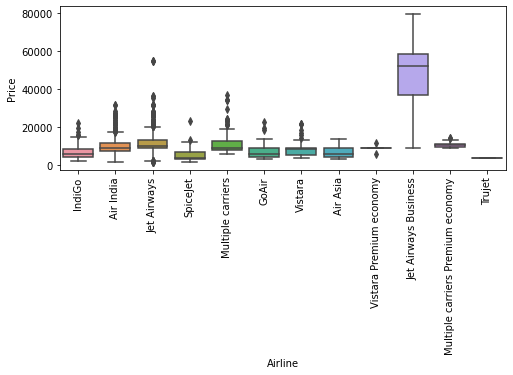

In [39]:
# Visualise Airline & Price column

plt.figure(figsize=(8,3))
sns.boxplot(data=df3, x='Airline', y='Price')
plt.xticks(rotation=90)

plt.show()

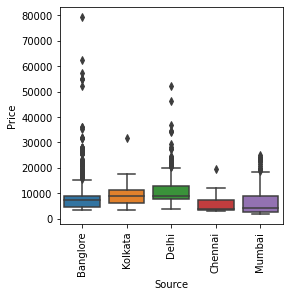

In [35]:
# Visualise Source & Price column

plt.figure(figsize=(4,4))
sns.boxplot(data=df3, x='Source', y='Price')
plt.xticks(rotation=90)

plt.show()

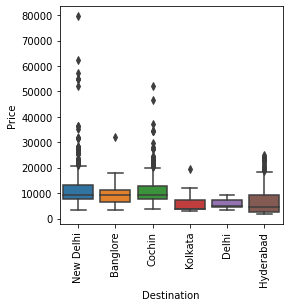

In [36]:
# Visualise Destination & Price column

plt.figure(figsize=(4,4))
sns.boxplot(data=df3, x='Destination', y='Price')
plt.xticks(rotation=90)

plt.show()

In [40]:
### Split [Date_of_Journey] to Date, Month & Year

df3['Date'] = df3['Date_of_Journey'].str.split('/').str[0]
df3['Month'] = df3['Date_of_Journey'].str.split('/').str[1]
df3['Year'] = df3['Date_of_Journey'].str.split('/').str[2]

In [41]:
### Convert Date, Month & Year to int

df3['Date'] = df3['Date'].astype(int)
df3['Month'] = df3['Month'].astype(int)
df3['Year'] = df3['Year'].astype(int)

In [42]:
## Drop ['Date_of_Journey']

df3 = df3.drop(['Date_of_Journey'],axis=1)


In [45]:
df3.head(3)

,Airline,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Date,Month,Year
0,IndiGo,Banglore,New Delhi,BLR → DEL,22:20,01:10,2h 50m,non-stop,No info,3897.0,24,3,2019
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662.0,1,5,2019
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25,19h,2 stops,No info,13882.0,9,6,2019


In [44]:
# Filter the Arrival Time


df3['Arrival_Time'] = df3['Arrival_Time'].str.split(' ').str[0]


In [46]:
# Convert [Total stops] to int

df3['Total_Stops'] = df3['Total_Stops'].replace('non-stop','0 stop')


In [47]:
# Filter & Rename 

df3['Stop'] = df3['Total_Stops'].str.split(' ').str[0]

In [ ]:
# Drop [Total Stops]

df3 = df3.drop(['Total_Stops'], axis=1)


In [49]:
df3.head(3)

,Airline,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Additional_Info,Price,Date,Month,Year,Stop
0,IndiGo,Banglore,New Delhi,BLR → DEL,22:20,01:10,2h 50m,No info,3897.0,24,3,2019,0
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,No info,7662.0,1,5,2019,2
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25,19h,No info,13882.0,9,6,2019,2


In [52]:
# Change Dtype to int

df3['Stop'] = df3['Stop'].astype(int)

In [53]:
# Filter [Arrival Type] into ['Arrival_Hour'] & ['Arrival_Minute']


df3['Arrival_Hour'] = df3['Arrival_Time'] .str.split(':').str[0]

df3['Arrival_Minute'] = df3['Arrival_Time'] .str.split(':').str[1]

In [54]:
# Change Dtype to int

df3['Arrival_Hour'] = df3['Arrival_Hour'].astype(int)

df3['Arrival_Minute'] = df3['Arrival_Minute'].astype(int)

df3 = df3.drop(['Arrival_Time'], axis=1)

In [55]:
# Filter ['Dep_Time'] into ['Depart_Hour'] & ['Depart_Minute']


df3['Depart_Hour'] = df3['Dep_Time'] .str.split(':').str[0]

df3['Depart_Minute'] = df3['Dep_Time'] .str.split(':').str[1]

In [56]:
# Change Dtype to int

df3['Depart_Hour'] = df3['Depart_Hour'].astype(int)

df3['Depart_Minute'] = df3['Depart_Minute'].astype(int)

df3 = df3.drop(['Dep_Time'],axis=1)

In [58]:
# Filter ['Route'] into ['Route_a'] ['Route_b'] ['Route_c]'

df3['Route_a'] = df3['Route'].str.split('→ ').str[0]
df3['Route_b'] = df3['Route'].str.split('→ ').str[1]
df3['Route_c'] = df3['Route'].str.split('→ ').str[2]
df3['Route_d'] = df3['Route'].str.split('→ ').str[3]
df3['Route_e'] = df3['Route'].str.split('→ ').str[4]

In [60]:
df3.head(3)

,Airline,Source,Destination,Route,Duration,Additional_Info,Price,Date,Month,Year,Stop,Arrival_Hour,Arrival_Minute,Depart_Hour,Depart_Minute,Route_a,Route_b,Route_c,Route_d,Route_e
0,IndiGo,Banglore,New Delhi,BLR → DEL,2h 50m,No info,3897.0,24,3,2019,0,1,10,22,20,BLR,DEL,NaN,NaN,NaN
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,No info,7662.0,1,5,2019,2,13,15,5,50,CCU,IXR,BBI,BLR,NaN
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,19h,No info,13882.0,9,6,2019,2,4,25,9,25,DEL,LKO,BOM,COK,NaN


In [61]:
# Drop ['Route'] and ['Duration']

df3 = df3.drop(['Route'], axis=1)
df3 = df3.drop(['Duration'], axis=1)

In [ ]:
#  df3['Route_1'].fillna("None",inplace=True)
# df3['Route_3'].fillna("None",inplace=True)
# df3['Route_4'].fillna("None",inplace=True)
# df3['Route_5'].fillna("None",inplace=True)

Label Encoder for changing Dtypes object to integer

In [63]:
### Convert remaining Columns to Integers

encoder = LabelEncoder()

In [65]:
df3["Airline"] = encoder.fit_transform(df3['Airline'])

df3["Source"] = encoder.fit_transform(df3['Source'])

df3["Destination"] = encoder.fit_transform(df3['Destination'])

df3["Additional_Info"] = encoder.fit_transform(df3['Additional_Info'])

df3["Route_a"] = encoder.fit_transform(df3['Route_a'])

df3["Route_b"] = encoder.fit_transform(df3['Route_b'])

df3["Route_c"] = encoder.fit_transform(df3['Route_c'])

df3["Route_d"] = encoder.fit_transform(df3['Route_d'])

df3["Route_e"] = encoder.fit_transform(df3['Route_e'])

In [66]:
df3.head(3)

,Airline,Source,Destination,Additional_Info,Price,Date,Month,Year,Stop,Arrival_Hour,Arrival_Minute,Depart_Hour,Depart_Minute,Route_a,Route_b,Route_c,Route_d,Route_e
0,3,0,5,8,3897.0,24,3,2019,0,1,10,22,20,0,13,30,13,5
1,1,3,0,8,7662.0,1,5,2019,2,13,15,5,50,2,25,1,3,5
2,4,2,1,8,13882.0,9,6,2019,2,4,25,9,25,3,32,4,5,5


In [67]:
# Drop ['Year']

df3 = df3.drop(['Year'], axis = 1)

In [68]:
df3.head(2)

,Airline,Source,Destination,Additional_Info,Price,Date,Month,Stop,Arrival_Hour,Arrival_Minute,Depart_Hour,Depart_Minute,Route_a,Route_b,Route_c,Route_d,Route_e
0,3,0,5,8,3897.0,24,3,0,1,10,22,20,0,13,30,13,5
1,1,3,0,8,7662.0,1,5,2,13,15,5,50,2,25,1,3,5


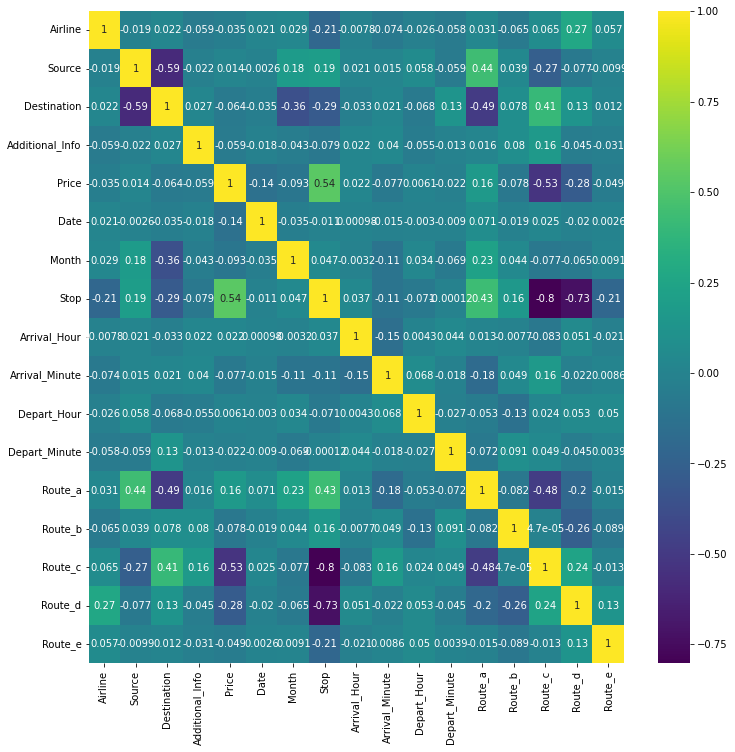

In [70]:
## Visualize Correlation using Heatmap

plt.figure(figsize=(12,12))
sns.heatmap(df3.corr(), annot=True,cmap='viridis')

plt.show()


Split Data into Dependent & Independent

In [71]:
X = df3.drop(columns = 'Price', axis=1)

Y = df3['Price']

In [72]:
#  Split the data into Training & Testing Data

Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2)


In [73]:
print(X.shape, Xtrain.shape, Xtest.shape)

(13354, 16) (10683, 16) (2671, 16)


Using XGBRegressor ML Model

In [74]:
regressor = XGBRegressor()

In [75]:
regressor.fit(Xtrain, Ytrain)

[18:33:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [76]:
# predict training data

pred = regressor.predict(Xtrain)

In [77]:
### Check the accuracy for Training Data


regressor_accuracy = round(regressor.score(Xtrain, Ytrain)*100,2)

print(round(regressor_accuracy, 2), '%')

68.99 %


In [78]:
### Check the accuracy for Test data

regressor_accuracy1 = round(regressor.score(Xtest, Ytest)*100,2)

print(round(regressor_accuracy1, 2), '%')


65.5 %


In [80]:
# Check R squared Value

r2_train = metrics.r2_score(Ytrain, pred)

print('R Squared value = ', r2_train)

R Squared value =  0.6898870655142286


Using RandomForestRegressor ML Model

In [92]:

random_model = RandomForestRegressor(n_estimators = 700, random_state = 42, n_jobs = -1)


In [93]:
### Predict Data

random_model.fit(Xtrain, Ytrain)

REF_pred = random_model.predict(Xtest)

print(REF_pred)


[4479.64551357 6275.14040344 5136.50650566 ... 7937.78010287 4409.01961808
 4585.68895736]


In [94]:
### Check the accuracy for Train

random_model_accuracy = round(random_model.score(Xtrain, Ytrain)*100,2)

print(round(random_model_accuracy, 2), '%')

94.91 %


In [95]:
### Check the accuracy for Test

random_model_accuracy1 = round(random_model.score(Xtest, Ytest)*100,2)

print(round(random_model_accuracy1, 2), '%')

64.29 %


In [96]:
### Check R Squared Value

r2_score(REF_pred, Ytest)

0.5634695963530214

In [97]:
### Display Actual and Predicted Data

pd.DataFrame(np.c_[Ytest , REF_pred], columns = ['Actual' , 'Predicted'])

,Actual,Predicted
0,4226.000000,4479.645514
1,6117.000000,6275.140403
2,9087.064121,5136.506506
3,10577.000000,11615.327548
4,9087.064121,12217.633233
...,...,...
2666,9087.064121,8766.811173
2667,6985.000000,7884.484565
2668,6953.000000,7937.780103
2669,3597.000000,4409.019618
